## Fun with Neural Networks Part 2.

Currently, the majority of work with neural networks has been in the regression/classification steps. For instance, people think about trying to predict a given output value, given a set of inputs. However, given the way that neural networks work, I think they can be easily extended to also find optimal solutions for unknown functions.

A few of the applications that I've been thinking about

1. Imagine we have a dataset in which patients are given a variety of different medication. We have measured the following, their genetic status, the drugs that they have been administered, and some outcome measure. For each patient, can we find an optimial combination of drugs to best handle their disease.

2. Certain features are important in terms of predicting things like solubility or target engagement, can we propose a new structure that will optimize solubility and/or binding.

So the overall thought is to use neural networks to do the basic prediction task, but then understand that the neural network gives a differentiable function that we can then use to find at least a local minima. 

One of the nicer things is that because neural networks already work via gradient descent, we can easily use the same NN solvers to find the optimal solutions

In [2]:
import warnings
import os

warnings.filterwarnings('ignore')

from json import load
import pandas as pd
import numpy as np
import keras.backend as K
import tensorflow as tf
import math

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Layer, Lambda
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt

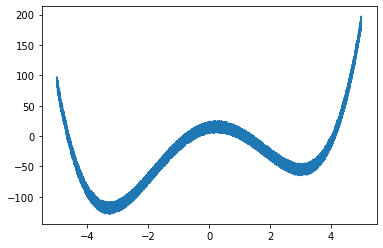

In [3]:
# This is just intended to generate some data for which the minima can be easily seen visually.
# It's a bit of a toy problem, but I think it's sufficient to illustrate the point. 
x = np.arange(0, 10000)/1000.0 - 5
y = x ** 4 - 20 * x ** 2 +  10 * x + 4 + np.random.rand(len(x)) * 20
plt.plot(x, y)

In [4]:
# reshape the matrix so it's compatible with keras
x = x.reshape(len(x), 1)

In [8]:
import ipywidgets

#this is our basic model that we're going to use to reconstruct the function

input_layer = Input(shape=(1,))
hidden_layer = Dense(12, activation='elu')(input_layer)
hidden_layer = Dense(9, activation='elu')(hidden_layer)
hidden_layer = Dense(6, activation='elu')(hidden_layer)
hidden_layer = Dense(3, activation='elu')(hidden_layer)
decoder = Dense(1, activation='linear')(hidden_layer)

model = Model(input_layer, decoder)
model.compile(loss='mse', optimizer='rmsprop')
model.fit(x, y, batch_size=16, epochs=20, validation_data=(x,y), verbose = 1)

Epoch 1/20
  5/625 [..............................] - ETA: 8s - loss: 4309.9453  

2023-02-11 09:16:36.881474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 3343.0188

2023-02-11 09:16:43.554128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 9s 15ms/step - loss: 3342.1365 - val_loss: 2489.3530
Epoch 2/20
625/625 [==============================] - 9s 14ms/step - loss: 2404.2532 - val_loss: 2350.3933
Epoch 3/20
625/625 [==============================] - 9s 14ms/step - loss: 2273.2334 - val_loss: 2182.6575
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 2068.1621 - val_loss: 1961.2555
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 1836.7909 - val_loss: 1716.8956
Epoch 6/20
625/625 [==============================] - 9s 14ms/step - loss: 1590.6882 - val_loss: 1466.8112
Epoch 7/20
625/625 [==============================] - 9s 14ms/step - loss: 1373.4333 - val_loss: 1270.5956
Epoch 8/20
625/625 [==============================] - 9s 14ms/step - loss: 1178.6851 - val_loss: 1081.4813
Epoch 9/20
625/625 [==============================] - 9s 14ms/step - loss: 1003.6282 - val_loss: 918.0468
Epoch 10/20
625/625 [============================

In [9]:
model.fit(x, y, batch_size=16, epochs=20, validation_data=(x,y), verbose = 1)

Epoch 1/20
625/625 [==============================] - 9s 14ms/step - loss: 175.9501 - val_loss: 163.1974
Epoch 2/20
625/625 [==============================] - 9s 14ms/step - loss: 158.6900 - val_loss: 147.0343
Epoch 3/20
625/625 [==============================] - 9s 14ms/step - loss: 141.4004 - val_loss: 130.5795
Epoch 4/20
625/625 [==============================] - 9s 14ms/step - loss: 125.9090 - val_loss: 111.0203
Epoch 5/20
625/625 [==============================] - 9s 14ms/step - loss: 112.1419 - val_loss: 139.4562
Epoch 6/20
625/625 [==============================] - 9s 14ms/step - loss: 103.3012 - val_loss: 112.5850
Epoch 7/20
625/625 [==============================] - 9s 14ms/step - loss: 96.0603 - val_loss: 91.3089
Epoch 8/20
625/625 [==============================] - 9s 14ms/step - loss: 91.8711 - val_loss: 83.4598
Epoch 9/20
625/625 [==============================] - 9s 14ms/step - loss: 87.7321 - val_loss: 73.9723
Epoch 10/20
625/625 [==============================] - 9s 14m

In [10]:
# predict the curve again. Yes this is a self prediction, but we'll leave the cross validation as 
# an exercise for the reader
p = model.predict(x)

2023-02-11 09:22:58.540828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


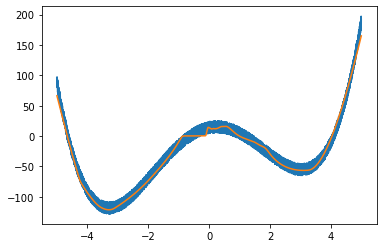

In [11]:
# unsurprisingly it is able to replicate the original function
plt.plot(x, y)
plt.plot(x, p)

In [8]:
# we're going to freeze the model
model.trainable = False

### Optimization

The previous section was a pretty straightforward data generation and training of the neural network. Within the next section we're going to be trying to find the optimal solution.

Essentailly, we want to have a "layer" whose weights can be optimized, and which serve as an input to the trained model. 

In [66]:
from scipy.optimize import minimize,shgo
import numdifftools as nd

def func2(x):
    return model.predict(x)[0][0]

f_jacob = nd.Jacobian(func2)

x0 = [0]
cons=({'type': 'ineq',
       'fun': lambda x: x[0] - 1})

result = minimize(func2, x0, constraints=cons, jac=f_jacob, method='COBYLA')


TypeError: shgo() got multiple values for argument 'bounds'

In [63]:
result

     fun: -56.51991653442383
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 22
  status: 1
 success: True
       x: array([3.1016625])

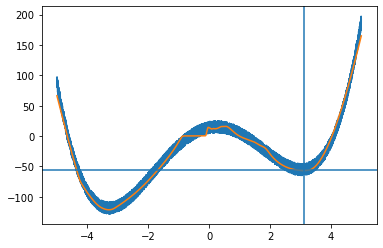

In [64]:
plt.plot(x, y)
plt.plot(x, p)

plt.axvline(x=result.x[0])
plt.axhline(y=result.fun)